<a href="https://colab.research.google.com/github/sraeisi/Machine_Learning_Physics_Winter20/blob/master/Chpt6/MLP_Chpt6_Lec1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, TimeDistributed
# %load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')

from tensorflow.keras.layers import LSTM, RNN, GRU, Dense, Dropout, TimeDistributed
from tensorflow.keras import layers
from tensorflow.keras import models

Running on GPU ...


In [2]:
n_ts = 6  ## Length of each time sequence or the forcast window
n_f = 1
n_prediction = 60

# Univariate RNN

### Data
For this part, we use the sunspot data. This data contains the mean value of the number of sunspots for each month from 1749. 

You can find more information about this dataset from [SIDC](http://www.sidc.be/silso/ssngraphics). 

In [3]:
data = pd.read_csv('monthly-sunspots.csv', index_col = 0)
# import requests, io
# url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/master/SampleData/monthly-sunspots.csv'
# c = requests.get(url, stream=True).content
# data = pd.read_csv(io.BytesIO(c), index_col = 0)

data.head()

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0


In [5]:
data.iloc[-1]

Sunspots    33.4
Name: 1983-12, dtype: float64

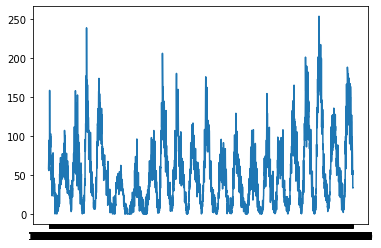

In [0]:
'''
Let's first plot the data to see if it does have a trend. 
'''
plt.plot(data.Sunspots)
plt.title = 'Sunspots in time'
plt.xlabel = 'Time (in month)'
plt.ylabel = 'Sunspots'
plt.show()

In [0]:
'''
As usuall, it is important to standardize/normalize the data. 
'''

print(f'The maximum value is {data.Sunspots.max()}')
data.Sunspots = data.Sunspots/data.Sunspots.max()

The maximum value is 253.8


### Generating the time-sequences

In [5]:
'''
The data in its current format, is not suitable for training a NN. 
We need to make the time-sequeces. 
For this, we add new columns to the dataframe and each new col 
is the same data but shifted. We create n_ts cols to collect
all the past n_ts data for each row. 
The output is a square matrix where each row is a time sequence. 
We also use the actual value as the target. 
'''
def prepare_time_seqs(data):
    output_df = pd.DataFrame()
    for i in range(n_ts):
        output_df[i] = data.Sunspots.shift(n_ts-i)
    output_df['target'] = data.Sunspots        
    return output_df


In [6]:
df = prepare_time_seqs(data)
df.head(10)

,0,1,2,3,4,5,target
Month,,,,,,,
1749-01,NaN,NaN,NaN,NaN,NaN,NaN,58.0
1749-02,NaN,NaN,NaN,NaN,NaN,58.0,62.6
1749-03,NaN,NaN,NaN,NaN,58.0,62.6,70.0
1749-04,NaN,NaN,NaN,58.0,62.6,70.0,55.7
1749-05,NaN,NaN,58.0,62.6,70.0,55.7,85.0
1749-06,NaN,58.0,62.6,70.0,55.7,85.0,83.5
1749-07,58.0,62.6,70.0,55.7,85.0,83.5,94.8
1749-08,62.6,70.0,55.7,85.0,83.5,94.8,66.3
1749-09,70.0,55.7,85.0,83.5,94.8,66.3,75.9


In [7]:
'''
The shift operator creates some NAN values since for the boundary, 
there's no value to be shifted forward. 
We can simply drop them. 
Note that if you want to increase n_ts, dropping the NaN values 
could result in significant data loss. 
'''
df.dropna(axis=0, inplace=True)
df.head()

,0,1,2,3,4,5,target
Month,,,,,,,
1749-07,58.0,62.6,70.0,55.7,85.0,83.5,94.8
1749-08,62.6,70.0,55.7,85.0,83.5,94.8,66.3
1749-09,70.0,55.7,85.0,83.5,94.8,66.3,75.9
1749-10,55.7,85.0,83.5,94.8,66.3,75.9,75.5
1749-11,85.0,83.5,94.8,66.3,75.9,75.5,158.6


In [99]:
'''
Next we form the X and Y. 
It is important to shape X to 
(n_s, n_ts, n_f)

For this example. n_f is one. 
'''

Y = df.target.values
Y = Y/Y.max()
X = df.drop('target', axis=1).values
print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(2814, 6)


(2814, 6, 1)

In [100]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(2065, 6, 1)


### Data: Quick

In [50]:
data = pd.read_csv('monthly-sunspots.csv', index_col = 0)
data.Sunspots = data.Sunspots/data.Sunspots.max()

def prepare_time_seqs(data):
    output_df = pd.DataFrame()
    for i in range(n_ts):
        output_df[i] = data.Sunspots.shift(n_ts-i)
    output_df['target'] = data.Sunspots        
    return output_df


df = prepare_time_seqs(data)
df.dropna(axis=0, inplace=True)


Y = df.target.values
X = df.drop('target', axis=1).values
X = X.reshape(-1, n_ts, 1)


X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)

## Many-to-Many

In [17]:
model = models.Sequential()  
model.add(LSTM(1, input_dim=1,  return_sequences=True, activation='tanh'))  
model.add(TimeDistributed(Dense(1)))
model.add(layers.Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop')  
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 1)           12        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           2         
_________________________________________________________________
activation (Activation)      (None, None, 1)           0         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [19]:
# model.fit(Y, Y)

## Convnet

In [57]:
# n_w , n_h = X_train[0].shape

model = models.Sequential()

model.add(layers.Conv1D(16, 3, activation='relu', input_shape= (6,1) ))
model.add(layers.MaxPooling1D(2))

# model.add(layers.Conv1D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling1D((3, 3)))


# model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))


model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 4, 16)             64        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 2, 16)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2, 64)             1088      
_________________________________________________________________
dense_17 (Dense)             (None, 2, 1)              65        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Train on 2065 samples, validate on 689 samples
Epoch 1/10
2065/2065 [==============================] - 8s 4ms/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/10
2065/2065 [==============================] - 1s 676us/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 3/10
2065/2065 [==============================] - 1s 674us/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 4/10
2065/2065 [==============================] - 1s 683us/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 5/10
2065/2065 [==============================] - 1s 645us/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 6/10
2065/2065 [==============================] - 1s 624us/sample - loss: 0.6931 - accuracy: 4.8426e-04 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 7/10
2065/206

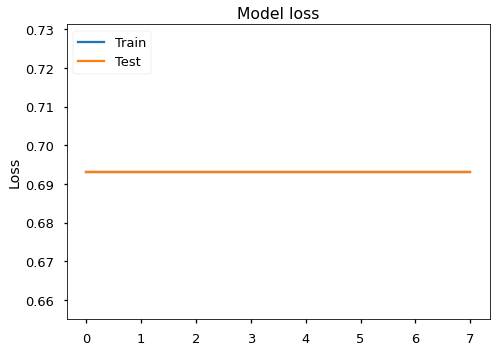

In [59]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Implementation of RNN

In [14]:
n_out = 1 ## Number of output features
n_h = 1 ## Number of units in the hidden layer. 
import torch

In [108]:
a_t = torch.zeros(n_h,1)  
'''This is essentially the memory, the info that 
circles back to the hidden unit in each itr. 
We initialize it to zero. '''


'''Next we initialize the random weight matrices.'''
## First for the hidden units
U_a = torch.rand(n_h, n_f)  ## This take x -> a
W_a = torch.rand(n_h, n_h)  ## This take a^{<t-1>} -> a^{<t>}
b_a = torch.rand(n_h,)

## And then for the output. 
W_y = torch.rand(n_out, n_h)  ## This takes a^{<t>}-> y^{<t>}
b_y = torch.rand(n_out,)

'''
We need to keep the outputs, i.e. the y values. 
Here we are assuming that this is a many-to-many network. 
One can skip the calculation of y to the end and only 
generate one single output. 
'''
y_list = []


In [71]:
'''
Let's first see how the feedforward loop works for a single input. 
'''
input_X = torch.Tensor(X_train[10]).view(n_ts, n_f, 1)
print(input_X.size())

for x in input_X:
        
    # First we update a_t (the hidden layer). 
    a_t = torch.tanh(  ## We use the tanh for the hidden layer activation
                    torch.mm( W_a, a_t )  +  ## This takes the a^{<t-1>} to a^{<t>}.
                    torch.mm( U_a, x )    +  ## This takes the x^{<t>} to a^{<t>}.
                    b_a)                      ## This is the bias for the hidden unit. 

    
# Next we calculate the output, y. 

y = torch.sigmoid(     ## We use the sigmoid for the output activation
                torch.mm( W_y, a_t )  +  ## This takes the a^{<t>} to y^{<t>}.                   
                b_y) 
#     y_list += [y]
    

torch.Size([6, 1, 1])


In [76]:
'''
Let's first see how the feedforward loop works. 
'''
for input_X in torch.Tensor(X_train).view(-1, n_ts, n_f, 1):
# print(input_X.size())
    for x in input_X:

        # First we update a_t (the hidden layer). 
        a_t = torch.tanh(  ## We use the tanh for the hidden layer activation
                        torch.mm( W_a, a_t )  +  ## This takes the a^{<t-1>} to a^{<t>}.
                        torch.mm( U_a, x )    +  ## This takes the x^{<t>} to a^{<t>}.
                        b_y)                      ## This is the bias for the hidden unit. 


    # Next we calculate the output, y. 

    y = torch.sigmoid(     ## We use the sigmoid for the output activation
                    torch.mm( W_y, a_t )  +  ## This takes the a^{<t>} to y^{<t>}.                   
                    b_y) 
    y_list += [y]
    

torch.Size([2065])


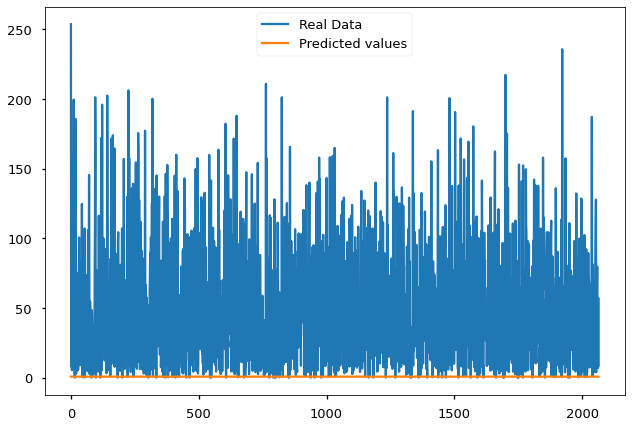

In [82]:
print(torch.Tensor(y_list).size())

plt.plot(Y_train, label = 'Real Data')
plt.plot(torch.Tensor(y_list), label = 'Predicted values')
plt.legend(loc=0)
plt.show()

Clearly, we need to change the activation function.

Then define the loss and train the network fit the data. 

In [105]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class BasicRNN(nn.Module):
    def __init__(self, n_features, n_neurons, n_out, times_steps):
        super(BasicRNN, self).__init__()
        
        self.n_f = n_features
        self.n_h = n_neurons
        self.n_out = n_out
        self.n_ts = times_steps

        self.a_t = torch.zeros(self.n_h,1)  
        '''This is essentially the memory, the info that 
        circles back to the hidden unit in each itr. 
        We initialize it to zero. '''


        '''Next we initialize the random weight matrices.'''
        ## First for the hidden units
        W_a = torch.rand(self.n_h, self.n_f)  ## This take x -> a
        U_a = torch.rand(self.n_h, self.n_h)  ## This take a -> a
        b_a = torch.rand(self.n_h,)

        ## And then for the output. 
        W_y = torch.rand(self.n_out, self.n_h)  ## This takes a-> y
        b_y = torch.rand(self.n_out,)

        '''
        We need to keep the outputs, i.e. the y values. 
        Here we are assuming that this is a many-to-many network. 
        One can skip the calculation of y to the end and only 
        generate one single output. 
        '''
        self.y_list = []      
    
    def forward(self, X):
        self.y_list = []
        
        for input_X in torch.Tensor(X).view(-1, self.n_ts, self.n_f, 1):
        # print(input_X.size())
            for x in input_X:
                # First we update a_t (the hidden layer). 
                self.a_t = torch.tanh(  ## We use the tanh for the hidden layer activation
                                torch.mm( W_a, self.a_t )  +  ## This takes the a^{<t-1>} to a^{<t>}.
                                torch.mm( U_a, x )    +  ## This takes the x^{<t>} to a^{<t>}.
                                b_y)                      ## This is the bias for the hidden unit. 


            # Next we calculate the output, y. 

            y = torch.sigmoid(     ## We use the sigmoid for the output activation
                            torch.mm( W_y, self.a_t )  +  ## This takes the a^{<t>} to y^{<t>}.                   
                            b_y) 
            self.y_list += [y]
        
                
        return self.y_list

In [106]:
rnn = BasicRNN(n_f, n_neurons=n_h, n_out=n_out, times_steps=n_ts)
# rnn.forward(X_train)

optimizer = optim.Adam(rnn.parameters(), lr=0.01, betas=(0.9, 0.999))

## Define a loss function: WE are using binary cross-entropy 
criterion = nn.BCELoss()
    

ValueError: optimizer got an empty parameter list

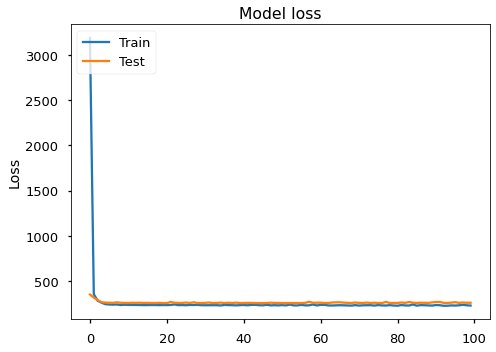

In [15]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

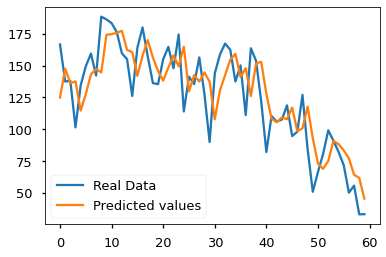

In [16]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.legend(loc=0)
plt.show()

## Simple RNN model

In [0]:
model = models.Sequential()
model.add(SimpleRNN(64, input_shape =(n_ts, n_f) , 
               activation='tanh', 
               return_sequences=True) 
         )

model.add(SimpleRNN(32,  activation='tanh')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 6, 64)             4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
130/130 [==============================] - 2s 17ms/step - loss: 3278.2493 - val_loss: 2564.6167
Epoch 2/10
130/130 [==============================] - 2s 15ms/step - loss: 1728.9303 - val_loss: 1257.2352
Epoch 3/10
130/130 [==============================] - 2s 15ms/step - loss: 862.2943 - val_loss: 713.4257
Epoch 4/10
130/130 [==============================] - 2s 15ms/step - loss: 540.4365 - val_loss: 480.5204
Epoch 5/10
130/130 [==============================] - 2s 15ms/step - loss: 410.8458 - val_loss: 403.9608
Epoch 6/10
130/130 [==============================] - 2s 16ms/step - loss: 349.5312 - val_loss: 344.1889
Epoch 7/10
130/130 [==============================] - 2s 15ms/step - loss: 314.5769 - val_loss: 311.6905
Epoch 8/10
130/130 [==============================] - 2s 15ms/step - loss: 296.9061 - val_loss: 307.3282
Epoch 9/10
130/130 [==============================] - 2s 14ms/step - loss: 285.3169 - val_loss: 290.5525
Epoch 10/10
130/130 [==============================

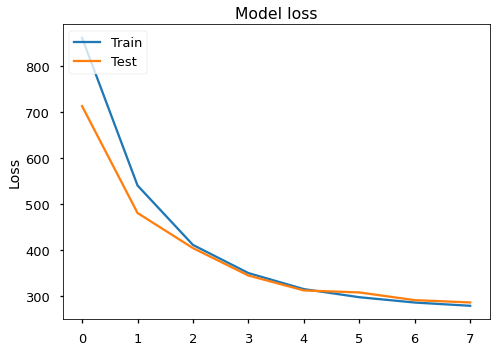

In [20]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

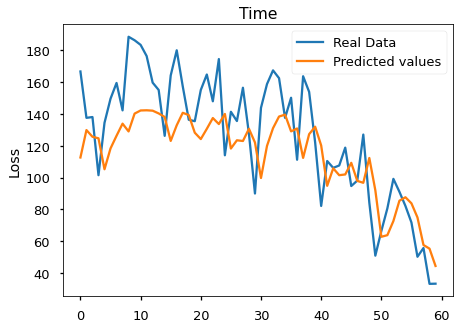

In [21]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()

## RNN with long short term memory (LSTM)

Next, we train a LSTM model. 

In [25]:
model = models.Sequential()
model.add(LSTM(64, input_shape =(n_ts, n_f) , 
               activation='relu', 
               return_sequences=True) 
         )

model.add(LSTM(32,  activation='relu')  )

model.add(Dense(32,  activation='relu')  )

model.add(Dense(1,  activation='linear')  )


model.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )


In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 6, 64)             16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, Y_train, 
                    epochs=10, batch_size=16, 
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
130/130 [==============================] - 5s 35ms/step - loss: 1806.4039 - val_loss: 285.1074
Epoch 2/10
130/130 [==============================] - 4s 32ms/step - loss: 293.6981 - val_loss: 279.4806
Epoch 3/10
130/130 [==============================] - 4s 33ms/step - loss: 266.5016 - val_loss: 281.9277
Epoch 4/10
130/130 [==============================] - 4s 33ms/step - loss: 271.6642 - val_loss: 271.5713
Epoch 5/10
130/130 [==============================] - 4s 34ms/step - loss: 276.9917 - val_loss: 277.7851
Epoch 6/10
130/130 [==============================] - 4s 33ms/step - loss: 265.6945 - val_loss: 275.5138
Epoch 7/10
130/130 [==============================] - 4s 33ms/step - loss: 264.6075 - val_loss: 280.7809
Epoch 8/10
130/130 [==============================] - 4s 33ms/step - loss: 262.5093 - val_loss: 278.0503
Epoch 9/10
130/130 [==============================] - 4s 34ms/step - loss: 265.4661 - val_loss: 275.7762
Epoch 10/10
130/130 [==============================] -

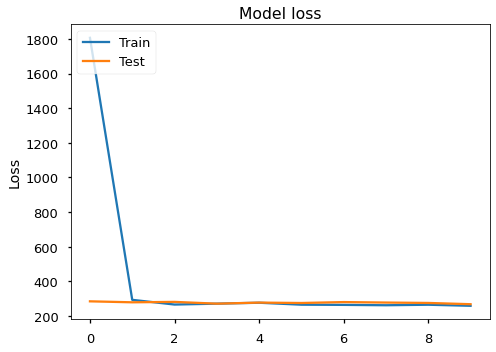

In [30]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

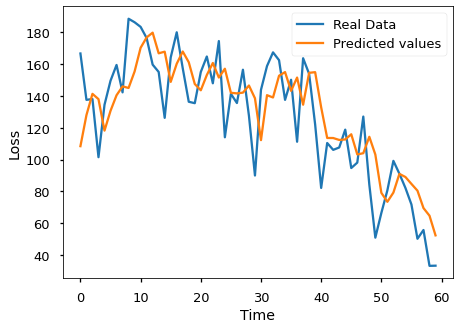

In [31]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()

# Multivariate RNN

In [32]:
'''
Here's the data for air pollution in Beijing, taken from 
http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data#

Use LSTM RNN models to predict the air pollution. 

'''
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
import requests, io

c = requests.get(url, stream=True).content
data = pd.read_csv(io.BytesIO(c), index_col = 0)
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [33]:
'''
We probably don't need year, month, day and hour if hour is always increasing by one. 
It should be enough to keep only the index. 
'''
data.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
data.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823,
            43824],
           dtype='int64', name='No', length=43824)

### Dealing with nan values

In [34]:
data.isna().any()

pm2.5     True
DEWP     False
TEMP     False
PRES     False
cbwd     False
Iws      False
Is       False
Ir       False
dtype: bool

In [35]:
data['pm2.5'].isna().sum()

2067

In [36]:
print(len(data))

43824


In [0]:
'''
There are two many of them and we can't just remove those rows. 
So we replace the NaN values with the mean of the col. 
'''

data.fillna(data.mean(), inplace=True)

In [38]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
3,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
4,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
5,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


In [39]:
'''
Next we need to turn categorical values to numerical ones. 
'''
data.cbwd = data.cbwd.astype("category").cat.codes
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,
1,98.613215,-21,-11.0,1021.0,1,1.79,0,0
2,98.613215,-21,-12.0,1020.0,1,4.92,0,0
3,98.613215,-21,-11.0,1019.0,1,6.71,0,0
4,98.613215,-21,-14.0,1019.0,1,9.84,0,0
5,98.613215,-20,-12.0,1018.0,1,12.97,0,0
6,98.613215,-19,-10.0,1017.0,1,16.10,0,0
7,98.613215,-19,-9.0,1017.0,1,19.23,0,0
8,98.613215,-19,-9.0,1017.0,1,21.02,0,0
9,98.613215,-19,-9.0,1017.0,1,24.15,0,0


In [0]:
'''
We also need to normalize the data. 
'''
# normalized_data=(data-data.mean())/data.std()
normalized_data=(data-data.min())/(data.max()-data.min())


In [41]:
n_f = data.shape[1] 
n_f

8

In [42]:
hist = range(1,n_ts+1)

df = normalized_data.assign(**{
    '{} (h-{})'.format(col, t): normalized_data[col].shift(t)
    for t in hist
    for col in normalized_data
})

df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5 (h-1),DEWP (h-1),TEMP (h-1),PRES (h-1),cbwd (h-1),Iws (h-1),Is (h-1),Ir (h-1),pm2.5 (h-2),DEWP (h-2),TEMP (h-2),PRES (h-2),cbwd (h-2),Iws (h-2),Is (h-2),Ir (h-2),pm2.5 (h-3),DEWP (h-3),TEMP (h-3),PRES (h-3),cbwd (h-3),Iws (h-3),Is (h-3),Ir (h-3),pm2.5 (h-4),DEWP (h-4),TEMP (h-4),PRES (h-4),cbwd (h-4),Iws (h-4),Is (h-4),Ir (h-4),pm2.5 (h-5),DEWP (h-5),TEMP (h-5),PRES (h-5),cbwd (h-5),Iws (h-5),Is (h-5),Ir (h-5),pm2.5 (h-6),DEWP (h-6),TEMP (h-6),PRES (h-6),cbwd (h-6),Iws (h-6),Is (h-6),Ir (h-6)
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.002290,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.099208,0.294118,0.114754,0.490909,0.333333,0.021396,0.0,0.0,0.099208,0.279412,0.081967,0.509091,0.333333,0.016047,0.0,0.0,0.099208,0.279412,0.131148,0.509091,0.333333,0.010698,0.0,0.0,0.099208,0.279412,0.114754,0.527273,0.333333,0.007639,0.0,0.0,0.099208,0.279412,0.131148,0.545455,0.333333,0.00229,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
### Next we get rid of the first n_ts rows that have nan values. 
df.dropna(axis=0, inplace=True)

In [44]:
### The target is the pollution of the day
Y = df['pm2.5'].values

### Then we get rid of all the measurements of that day. 
X = df.drop(data.columns, axis=1).values

print(X.shape)
X = X.reshape(-1, n_ts, n_f)
X.shape

(43818, 48)


(43818, 6, 8)

In [0]:
'''
Before generating the train and validation sets, let's 
hold a portion of the data for prediction. 
We seperate the data for the last n_prediction 
months and later test to see how well our model 
can predict the target for these months. 
'''
X_future = X[-n_prediction:]
Y_future = Y[-n_prediction:]

X = X[:-n_prediction]
Y = Y[:-n_prediction]

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(32818, 6, 8)


In [0]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

In [48]:
model2 = keras.models.Sequential()
model2.add(LSTM(64, input_shape =(n_ts, n_f) , 
                     return_sequences=True)  )
model2.add(Dropout(.1))

model2.add(LSTM(32)  )
model2.add(Dropout(.2))

model2.add(Dense(32,  activation='relu')  )
model2.add(Dropout(.2))

model2.add(Dense(1,  activation='linear')  )


model2.compile(loss = keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr = .001) )
history2 = model2.fit(X_train, Y_train, epochs=50, 
                      batch_size=16, verbose=1, 
                      validation_data=(X_test, Y_test))


Epoch 1/50
2052/2052 [==============================] - 15s 8ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 2/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0013 - val_loss: 8.4883e-04
Epoch 3/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0012 - val_loss: 9.4463e-04
Epoch 4/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0011 - val_loss: 7.7508e-04
Epoch 5/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0011 - val_loss: 8.7953e-04
Epoch 6/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
2052/2052 [==============================] - 15s 7ms/step - loss: 0.0010 - val_loss: 6.9995e-04
Epoch 8/50
2052/2052 [==============================] - 15s 7ms/step - loss: 9.9189e-04 - val_loss: 7.0381e-04
Epoch 9/50
2052/2052 [==============================] - 14s 7ms/step - loss: 9.7491e-04 - val_loss: 6.9939e-04
Epoch 10/50
2052/2052 [==============

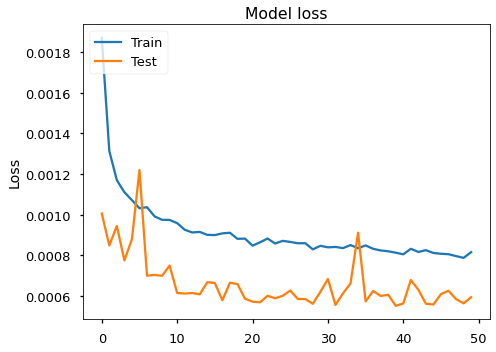

In [49]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(7,5))
# Plot training & validation loss values
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

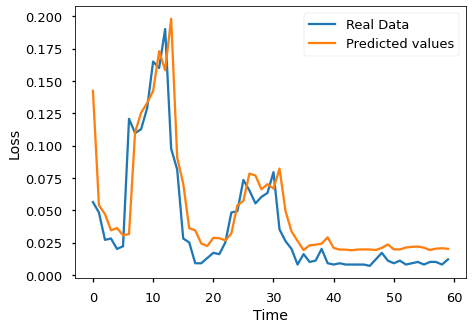

In [50]:
'''
Now we use the model to predict the sunspots for the missing month 
and then compare to the actual values. 
From the plot it is clear that the predicted values follow the trend, 
however, there seems to be a delay. 
'''
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, xlabel = 'Time', ylabel= 'Loss')

Y_fut_predicted = model2.predict(X_future)
plt.plot(Y_future, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.xlabel = 'time'
plt.legend(loc=0)
plt.show()